In [9]:
import mir_eval
import numpy as np
import scipy.interpolate
import csv
import os
import mirdata
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
def interp_with_zeros(x, y, kind, x_new):
    # interpolate smoothly
    smooth_resampled = scipy.interpolate.interp1d(x, y, kind)(x_new)

    # If there's a zero, resample 0's everywhere until the next nonzero value
    resampler_mask = (scipy.interpolate.interp1d(x, y, 'previous')(x_new) * 
                      scipy.interpolate.interp1d(x, y, 'next')(x_new))

    return smooth_resampled * (resampler_mask != 0)


def resample_melody_series(times, frequencies, voicing,
                           times_new, kind='linear'):
    """Resamples frequency and voicing time series to a new timescale. Maintains
    any zero ("unvoiced") values in frequencies.
    If ``times`` and ``times_new`` are equivalent, no resampling will be
    performed.

    Parameters
    ----------
    times : np.ndarray
        Times of each frequency value
    frequencies : np.ndarray
        Array of frequency values, >= 0
    voicing : np.ndarray
        Boolean array which indicates voiced or unvoiced
    times_new : np.ndarray
        Times to resample frequency and voicing sequences to
    kind : str
        kind parameter to pass to scipy.interpolate.interp1d.
        (Default value = 'linear')

    Returns
    -------
    frequencies_resampled : np.ndarray
        Frequency array resampled to new timebase
    voicing_resampled : np.ndarray, dtype=bool
        Voicing array resampled to new timebase
    """
    assert kind in ['linear', 'quadratic', 'cubic']
    
    # If the timebases are already the same, no need to interpolate
    if times.shape == times_new.shape and np.allclose(times, times_new):
        return frequencies, voicing.astype(np.bool)

    # Warn when the delta between the original times is not constant,
    if not (np.allclose(np.diff(times), np.diff(times).mean())):
        warnings.warn(
            "Non-uniform timescale passed to resample_melody_series.  Pitch "
            "will be linearly interpolated, which will result in undesirable "
            "behavior if silences are indicated by missing values.  Silences "
            "should be indicated by nonpositive frequency values.")

    # interpolate frequencies
    frequencies_resampled = interp_with_zeros(times, frequencies, kind, times_new)
    voicing_resampled = interp_with_zeros(times, voicing, kind, times_new)

    return frequencies_resampled, voicing_resampled

In [47]:
def frequency_comparison(est_freqs, ref_freqs, tolerance):
    freq_diff_semitones = 12.0*np.log2(est_freqs/ref_freqs)
    freq_diff_semitones[np.logical_or(est_freqs==0, ref_freqs==0)] = np.inf
    return np.abs(freq_diff_semitones) < tolerance


def chroma_comparison(est_freqs, ref_freqs, tolerance):
    # TODO: there's a bug here somewhere, find it!
    freq_diff_semitones = 12.0*np.log2(est_freqs/ref_freqs)
    freq_diff_semitones[np.logical_or(est_freqs==0, ref_freqs==0)] = np.inf
    return np.abs(np.mod(freq_diff_semitones, 12.0)) < tolerance


def raw_pitch_accuracy(ref_freqs, ref_voicing, est_freqs):
    correct_frequencies = frequency_comparison(est_freqs, ref_freqs, 0.5)
    return np.sum(ref_voicing * correct_frequencies) / np.sum(ref_voicing)


def raw_chroma_accuracy(ref_freqs, ref_voicing, est_freqs):
    correct_frequencies = chroma_comparison(est_freqs, ref_freqs, 0.5)
    return np.sum(ref_voicing * correct_frequencies) / np.sum(ref_voicing)


def voicing_recall(ref_voicing, est_voicing):
    return np.sum(est_voicing * ref_voicing) / np.sum(ref_voicing)


def voicing_precision(ref_voicing, est_voicing):
    return np.sum(est_voicing * ref_voicing) / np.sum(est_voicing)


def voicing_false_alarm(ref_voicing, est_voicing):
    return np.sum((1.0 - est_voicing) * (1.0 - ref_voicing)) / np.sum(1.0 - ref_voicing)


def overall_accuracy(ref_freqs, ref_voicing, est_freqs, est_voicing):
    correct_frequencies = frequency_comparison(est_freqs, ref_freqs, 0.5)
    N = float(len(ref_freqs))
    numerator = (ref_voicing * est_voicing * correct_frequencies) + \
        ((1 - ref_voicing)*(1-est_voicing))
    denominator = np.abs(ref_voicing - 0.5) + 0.5
    return (1./N)*np.sum(numerator / denominator)


In [48]:
def evaluate(ref_times, ref_freqs, ref_voicing, est_times, est_freqs, est_voicing):
    est_freqs_resampled, est_voicing_resampled = resample_melody_series(
        est_times, est_freqs, est_voicing, ref_times, 'linear')

    plt.figure(figsize=(15, 7))
    plt.title("With resampling")
    plt.subplot(211)
    plt.plot(ref_times, ref_freqs, '.k', markersize=15)
    plt.plot(ref_times, est_freqs_resampled, '.b')
    plt.subplot(212)
    plt.plot(ref_times, ref_voicing, 'k')
    plt.plot(ref_times, est_voicing_resampled, 'b')
    plt.show()
    
    metrics = {}
    metrics['Overall Accuracy'] = overall_accuracy(
        ref_freqs, ref_voicing, est_freqs_resampled, est_voicing_resampled)
    metrics['Raw Pitch Accuracy'] = raw_pitch_accuracy(
        ref_freqs, ref_voicing, est_freqs_resampled)
    metrics['Raw Chroma Accuracy'] = raw_chroma_accuracy(
        ref_freqs, ref_voicing, est_freqs_resampled)
    metrics['Voicing Recall'] = voicing_recall(ref_voicing, est_voicing_resampled)
    metrics['Voicing Precision'] = voicing_precision(ref_voicing, est_voicing_resampled)
    metrics['Voicing False Alarm'] = voicing_false_alarm(ref_voicing, est_voicing_resampled)
    
    return metrics

In [15]:
def load_deepsalience(fpath):
    with open(fpath, 'r') as fhandle:
        reader = csv.reader(fhandle, delimiter='\t')
        times, freqs, conf = [], [], []
        for line in reader:
            times.append(float(line[0]))
            freqs.append(float(line[1]))
            conf.append(float(line[2]))
    return np.array(times), np.array(freqs), np.array(conf)


def deepsalience_outputs(outputs_path):
    output_dict = {}
    ikala_index = mirdata.ikala.track_ids()
    for tid in ikala_index:
        output_dict[tid] = os.path.join(
            outputs_path, "deepsalience", "ikala",
            "{}_melody2_singlef0.csv".format(tid))
    mdb_mel_index = mirdata.medleydb_melody.track_ids()
    for tid in mdb_mel_index:
        output_dict[tid] = os.path.join(
            outputs_path, "deepsalience", "medleydb-melody",
            "{}_melody2_singlef0.csv".format(tid))
    return output_dict

In [10]:
deepsalience_paths = deepsalience_outputs("/Users/rachelbittner/Documents/repos/continuousf0eval/algorithm_outputs")

In [5]:
ikala_data = mirdata.ikala.load()

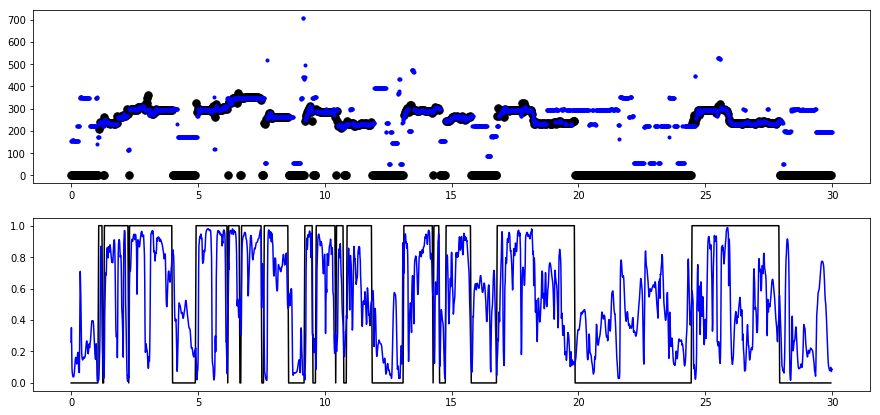

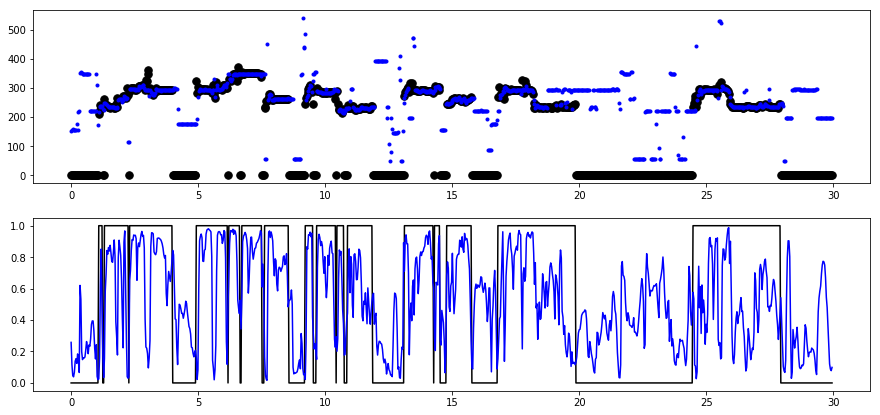

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


In [52]:
scores = {}
scores_mireval = {}
for tid, track_data in ikala_data.items():
    ref_times = track_data.f0.times
    ref_freqs = track_data.f0.frequencies
    ref_conf = (ref_freqs > 0).astype(float)
    
    est_times, est_freqs, est_conf = load_deepsalience(deepsalience_paths[tid])
    est_freqs_multiplier = np.ones(est_freqs.shape)
    est_freqs_multiplier[est_conf < 0.5] = -1.0

    plt.figure(figsize=(15, 7))
    plt.title("before resampling")
    plt.subplot(211)
    plt.plot(ref_times, ref_freqs, '.k', markersize=15)
    plt.plot(est_times, est_freqs, '.b')
    plt.subplot(212)
    plt.plot(ref_times, ref_conf, 'k')
    plt.plot(est_times, est_conf, 'b')
    plt.show()
    
    scores[tid] = evaluate(ref_times, ref_freqs, ref_conf, est_times, est_freqs, est_conf)
    scores_mireval[tid] = mir_eval.melody.evaluate(
        ref_times, ref_freqs, est_times, est_freqs*est_freqs_multiplier)
    break

In [53]:
scores['10161_chorus']

{'Overall Accuracy': 0.605768817672819,
 'Raw Pitch Accuracy': 0.7956204379562044,
 'Raw Chroma Accuracy': 0.2846715328467153,
 'Voicing Recall': 0.6508290244329835,
 'Voicing Precision': 0.7251709697953522,
 'Voicing False Alarm': 0.6525277991391549}

In [54]:
scores_mireval['10161_chorus']

OrderedDict([('Voicing Recall', 0.7244525547445255),
             ('Voicing False Alarm', 0.2467866323907455),
             ('Raw Pitch Accuracy', 0.7956204379562044),
             ('Raw Chroma Accuracy', 0.7974452554744526),
             ('Overall Accuracy', 0.6894343649946638)])

In [46]:
np.mod?

In [36]:
# test_t_in = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
# test_t_out = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
# test_f_in = [0, 440, 500, 600, 0, 440]
# test = scipy.interpolate.interp1d(test_t_in, test_f_in, 'previous')
# test2 = scipy.interpolate.interp1d(test_t_in, test_f_in, 'next')
# test_lin = scipy.interpolate.interp1d(test_t_in, test_f_in, 'linear')

# test_f_out = test(test_t_out)
# test_f_out2 = test2(test_t_out)
# test_f_out_lin = test_lin(test_t_out)

# plt.figure()
# plt.subplot(3,1,1)
# plt.plot(test_t_in, test_f_in, 'or')
# plt.plot(test_t_out, test_f_out, '.b')
# plt.plot(test_t_out, test_f_out_lin, '.g')
# plt.subplot(3,1,2)
# plt.plot(test_t_in, test_f_in, 'or')
# plt.plot(test_t_out, test_f_out2, '.b')
# plt.plot(test_t_out, test_f_out_lin, '.g')
# plt.subplot(3,1,3)
# plt.plot(test_t_in, test_f_in, 'or')
# plt.plot(test_t_out, (test_f_out != 0)*(test_f_out2 != 0)*test_f_out_lin, '.b')
# plt.show()